In [11]:
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import tifffile
import yaml

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [9]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.data.user_points as points
import mushroom.data.he as he
import mushroom.data.multiplex as multiplex
import mushroom.data.xenium as xenium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [6]:
run_dir = '/data/estorrs/mushroom/data/projects/examples/full_workflow'
mushroom_dir = os.path.join(run_dir, f'mushroom_points') # where mushroom results will be saved
Path(mushroom_dir).mkdir(parents=True, exist_ok=True)

## specify inputs

In [7]:
metadata = yaml.safe_load(open(os.path.join(run_dir, 'registered', 'metadata.yaml')))
yaml.safe_dump(metadata, sys.stdout)

resolution: 1.0
sections:
- data:
  - dtype: visium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad
  - dtype: he
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif
  position: 0
  sid: S18-9906-U1
- data:
  - dtype: xenium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad
  position: 5
  sid: S18-9906-U2
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s2_S18-9906-U3_multiplex.ome.tiff
  position: 10
  sid: S18-9906-U3
- data:
  - dtype: xenium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s3_S18-9906-U9_xenium.h5ad
  position: 40
  sid: S18-9906-U9
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s4_S18-9906-U10_multiplex.ome.tiff
  positi

In [8]:
metadata['sections'] = metadata['sections'][:2]
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad'}],
   'position': 5,
   'sid': 'S18-9906-U2'}],
 'target_sid': 'S18-9906-U2'}

In [10]:
# convert the xenium to points data
adata = xenium.adata_from_xenium(metadata['sections'][-1]['data'][0]['filepath'])
adata

AnnData object with n_obs × n_vars = 270707 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial'
    obsm: 'spatial'

In [12]:
df = pd.DataFrame(data=adata.obsm['spatial'], columns=['x', 'y'])
df['cell_id'] = adata.obs.index.to_list()

exp_df = pd.DataFrame(data=adata.X, columns=adata.var.index.to_list())
df = pd.concat((df, exp_df), axis=1)
df

,x,y,cell_id,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,...,TRAC,TREM2,TSPAN19,UBE2C,UMOD,UPK3B,VCAN,VSIG4,VWA5A,VWF
0,609,6766,aaaaeola-1,0.0,0.0,0.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,623,6755,aaaajila-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,648,6758,aaaanfic-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,656,6739,aaabahgj-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,675,6753,aaabbmfm-1,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270702,7454,3462,oikpalga-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270703,7442,3465,oikpboip-1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270704,7449,3465,oikpfidj-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
270705,7524,3467,oikpoebe-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [20]:
img = he.read_he('/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif')
df['fullres_width'] = img.shape[1]
df['fullres_height'] = img.shape[0]
df

,x,y,cell_id,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,...,TSPAN19,UBE2C,UMOD,UPK3B,VCAN,VSIG4,VWA5A,VWF,fullres_width,fullres_height
0,609,6766,aaaaeola-1,0.0,0.0,0.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8460,8695
1,623,6755,aaaajila-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8460,8695
2,648,6758,aaaanfic-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8460,8695
3,656,6739,aaabahgj-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8460,8695
4,675,6753,aaabbmfm-1,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8460,8695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270702,7454,3462,oikpalga-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8460,8695
270703,7442,3465,oikpboip-1,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8460,8695
270704,7449,3465,oikpfidj-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8460,8695
270705,7524,3467,oikpoebe-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8460,8695


In [21]:
df.to_csv('/data/estorrs/sandbox/test_points.csv', index=False)


In [30]:
next(iter(adata.uns['spatial'].values()))['scalefactors']

{'spot_diameter_fullres': 10.0, 'tissue_hires_scalef': 0.4705882352941177}

In [14]:
metadata['sections'][-1]['data'][0]['filepath'] = '/data/estorrs/sandbox/test_points.csv'
metadata['sections'][-1]['data'][0]['dtype'] = 'points'
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'points',
     'filepath': '/data/estorrs/sandbox/test_points.csv'}],
   'position': 5,
   'sid': 'S18-9906-U2'}],
 'target_sid': 'S18-9906-U2'}

In [15]:
DEFAULT_CONFIG

{'sections': None,
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'tiling_method': 'radius'}}},
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution': 1.0,
  'target_resolution': 0.02,
  'pct_expression': 0.05,
  'log_base': 2.718281828459045,
  'tiling_method': 'grid',
  'tiling_radius': 1.0,
  'batch_size': 128,
  'num_workers': 0,
  'devices': 1,
  'accelerator': 'cpu',
  'max_epochs': 1,
  'steps_per_epoch': 1000,
  'lr': 0.0001,
  'out_dir': './outputs',
  'save_every': 1,
  'log_every_n_steps': 10,
  'logger_type': 'tensorboard',
  'logger_project': 'portobello',
  'channel_mapping': {},
  'data

In [16]:
config = deepcopy(DEFAULT_CONFIG)
config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': metadata['resolution'] / 50.,
        'out_dir': os.path.join(mushroom_dir, 'outputs'),
        'accelerator': 'gpu',
        'steps_per_epoch': 250,
    }
})
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'points',
     'filepath': '/data/estorrs/sandbox/test_points.csv'}],
   'position': 5,
   'sid': 'S18-9906-U2'}],
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'tiling_method': 'radius'}}},
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution

In [15]:
# fps = [mapping['filepath'] 
#        for item in config['sections']
#        for mapping in item['data']
#        if 'multiplex' == mapping['dtype']]
# multiplex.get_channel_counts(fps)

In [18]:
config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
    'visium': {
        'trainer_kwargs': {
            'target_resolution': .01 # lower resolution for visium
        }
    }
})
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'points',
     'filepath': '/data/estorrs/sandbox/test_points.csv'}],
   'position': 5,
   'sid': 'S18-9906-U2'}],
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'tiling_method': 'radius',
    'target_resolution': 0.01}}},
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trai

## train mushroom

In [31]:
mushroom = Mushroom.from_config(config)

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['S18-9906-U1', 'S18-9906-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section S18-9906-U1
INFO:root:generating image data for section S18-9906-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('S18-9906-U1', 'he'), ('S18-9906-U1_dup', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for points
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting points processing
INFO:root:using 148 channels
INFO:root:2 sections detecte

In [32]:
mushroom.section_ids

[('S18-9906-U1', 'visium'), ('S18-9906-U1', 'he'), ('S18-9906-U2', 'points')]

In [33]:
spore = mushroom.dtype_to_spore['points']
section_to_img = spore.train_dl.dataset.section_to_img
section_to_img.keys()

dict_keys([('S18-9906-U2', 'points'), ('S18-9906-U2_dup', 'points')])

In [34]:
img = section_to_img[('S18-9906-U2', 'points')]
img.shape

torch.Size([148, 170, 174])

In [35]:
mushroom.train()

INFO:root:starting training for he
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/he_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.868    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/he_chkpts/last-v1.ckpt
INFO:root:starting training for points
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.8 M 
------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.040    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training points, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/points_chkpts/last.ckpt
INFO:root:starting training for visium
Missing logger folder: /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/visium_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 24.9 M
------------------------------
24.9 M    Trainable params
0         Non-trainable params
24.9 M    Total params
99.591    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training visium, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs/visium_chkpts/last.ckpt


In [36]:
mushroom.embed_sections()

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding points spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

he


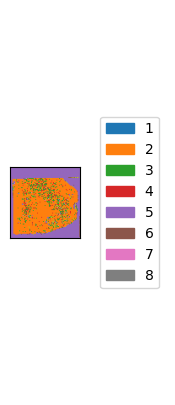

points


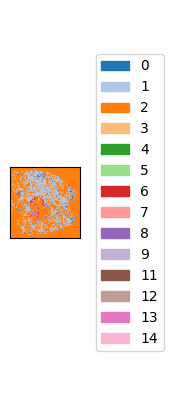

visium


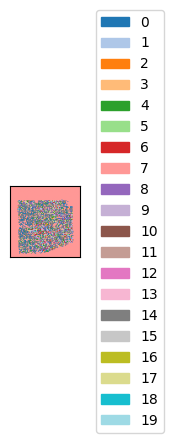

In [37]:
for dtype in mushroom.dtypes:
    print(dtype)
    mushroom.display_clusters(dtype)
    plt.show()

he


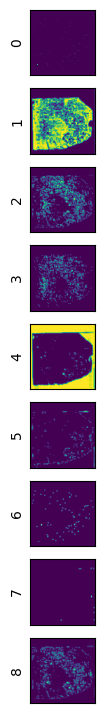

points


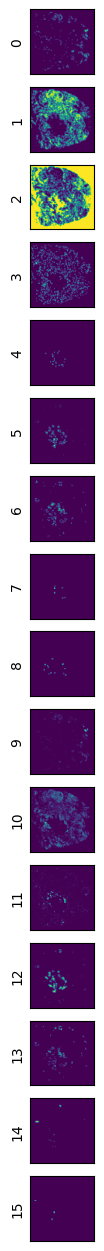

visium


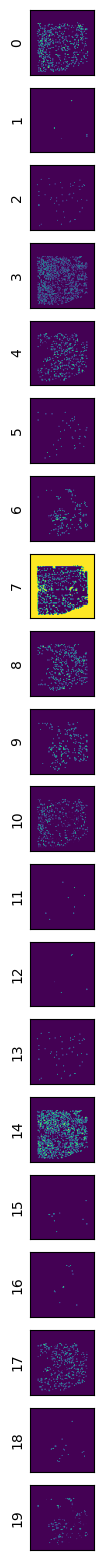

In [38]:
for dtype in mushroom.dtypes:
    print(dtype)
    mushroom.display_cluster_probs(dtype)
    plt.show()

In [39]:
%%time
z_scaler = .1
cluster_res = 1.5
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=0, resolution=cluster_res)

INFO:root:generating volume for he spore
INFO:root:generating volume for points spore
INFO:root:generating volume for visium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 3249 edges
INFO:root:323 edges remaining after filtering
INFO:root:57 of 57 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 8 clusters


CPU times: user 3.43 s, sys: 300 ms, total: 3.73 s
Wall time: 662 ms


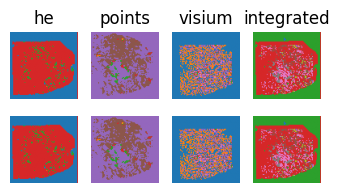

In [40]:
mushroom.display_volumes()

In [41]:
%%time
z_scaler = .1
cluster_res = 2.
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=2, resolution=cluster_res)

INFO:root:generating volume for he spore
INFO:root:generating volume for points spore
INFO:root:generating volume for visium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 15625 edges
INFO:root:2399 edges remaining after filtering
INFO:root:125 of 125 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 13 clusters


CPU times: user 4.63 s, sys: 384 ms, total: 5.02 s
Wall time: 864 ms


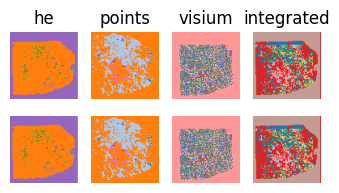

In [42]:
mushroom.display_volumes()

In [43]:
dtype_to_df = mushroom.calculate_cluster_intensities()
dtype_to_df.keys()

dict_keys(['he', 'points', 'visium'])

In [44]:
dtype_to_df['visium']

,A2M,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZSCAN30,ZSWIM7,ZSWIM8,ZSWIM9,ZW10,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,1.187053,0.499307,0.445058,0.209886,0.464251,0.334939,0.594624,0.543422,0.583354,0.305735,...,0.386931,0.435523,0.438831,0.479371,0.525856,0.435280,0.368968,0.458380,0.889570,0.542204
1,17.768143,7.903230,8.980063,7.432248,7.816286,5.541101,9.552580,7.993421,12.079862,6.284127,...,6.196802,6.059349,8.280952,7.383624,5.728956,8.540316,7.802409,6.639308,13.648779,11.718113
2,2.501567,1.066632,1.065081,0.737488,1.039602,0.749703,1.281799,1.127111,1.428578,0.739868,...,0.845975,0.872633,1.035790,0.966284,0.960957,1.054024,0.910833,0.920642,1.900482,1.372827
3,1.741341,0.739860,0.683082,0.362512,0.707227,0.506342,0.858531,0.804228,0.884826,0.464358,...,0.561785,0.623636,0.676796,0.684374,0.751003,0.649879,0.588075,0.665220,1.305450,0.841486
4,5.276757,2.278952,2.413446,1.831515,2.233065,1.652403,2.728809,2.384095,3.316789,1.724821,...,1.851289,1.834512,2.376813,2.150257,1.892382,2.463449,2.123089,2.046495,4.001000,3.112783
5,8.189195,3.575239,4.004889,3.218565,3.588557,2.657198,4.387463,3.691976,5.354186,2.869187,...,2.912468,2.750737,3.918112,3.369267,2.715155,3.942619,3.446313,3.129850,6.189943,5.169946
6,9.241258,4.083270,4.637372,3.741802,4.089702,3.089680,4.955411,4.172431,6.153493,3.287693,...,3.259561,3.108711,4.451698,3.773269,3.036242,4.558096,3.902372,3.559870,6.963007,5.951470
7,-1.021602,-0.458957,-0.465018,-0.368446,-0.461905,-0.379931,-0.508333,-0.484321,-0.646180,-0.328231,...,-0.343031,-0.323154,-0.515826,-0.386592,-0.412038,-0.478091,-0.416129,-0.458689,-0.762154,-0.618513
8,6.463223,2.825454,3.060682,2.333940,2.786930,2.042519,3.434125,2.949759,4.140293,2.195920,...,2.255718,2.285940,2.943860,2.673677,2.306698,3.008696,2.615935,2.537309,4.885118,3.937871
9,7.742514,3.367511,3.747428,2.982490,3.363737,2.493107,4.152280,3.493575,5.018136,2.696335,...,2.774243,2.623265,3.677130,3.191212,2.586250,3.696354,3.248691,2.976641,5.855147,4.826832


In [45]:
dtype_to_df = mushroom.calculate_cluster_intensities(projection_dtype='visium')
dtype_to_df.keys()

dict_keys(['he', 'points', 'visium'])

In [46]:
dtype_to_df['points']

,ACTA2,ACTG2,ADAMTS1,ADGRL4,AIF1,ALDH1A3,AMY2A,ANPEP,APCDD1,APOLD1,...,TFPI,THAP2,THY1,TMC5,TMEM100,TNC,TRAC,VCAN,VWA5A,VWF
0,2.232771,2.492812,1.819542,1.089164,1.423078,2.154638,1.776322,1.227928,2.137914,1.219630,...,1.969779,1.734438,1.402717,1.569543,1.373208,1.437579,1.127416,1.506344,1.510056,1.036387
1,2.932009,3.687070,2.959797,2.511807,5.003944,3.608408,3.654716,2.100903,3.979677,2.479743,...,3.599324,3.483672,3.579729,2.937658,2.598293,3.790443,4.421997,3.815007,3.524525,2.244399
2,1.985289,2.167587,1.530597,0.811222,0.939603,1.687893,1.407074,0.929241,1.706503,0.935779,...,1.584365,1.335460,1.048163,1.206158,1.029946,1.053638,0.700244,1.112104,1.153671,0.797444
3,2.990278,3.242685,2.442310,1.418994,1.022413,3.496340,2.213694,2.155959,2.963699,1.715392,...,2.694703,2.443498,1.486920,2.409566,2.229222,1.539070,0.641887,1.709971,1.759444,1.328350
4,2.372471,2.672713,1.980181,1.238253,1.674425,2.414832,1.977050,1.392306,2.373593,1.376071,...,2.180346,1.954721,1.590563,1.770265,1.562756,1.637772,1.345752,1.718978,1.700591,1.167323
5,2.382318,2.625138,1.924525,1.118911,1.205286,2.420766,1.813990,1.419113,2.267537,1.294336,...,2.083449,1.841551,1.346156,1.719683,1.535985,1.379613,0.897204,1.475841,1.499927,1.063149
6,2.299120,2.702736,2.030128,1.439707,2.500854,2.330030,2.229550,1.319302,2.517349,1.495316,...,2.307412,2.107470,2.007263,1.813294,1.574008,2.084417,2.137712,2.120022,2.037026,1.324589
7,1.461776,1.553903,0.994385,0.373268,0.428543,0.739186,0.817513,0.313383,0.943558,0.448108,...,0.905537,0.639058,0.573657,0.521110,0.369035,0.546691,0.279342,0.555410,0.640837,0.418466
8,2.469024,2.780726,2.072617,1.307958,1.707620,2.594850,2.066247,1.518804,2.506342,1.459972,...,2.296967,2.070361,1.646582,1.893005,1.686932,1.703501,1.363181,1.790544,1.774109,1.223999
9,2.322067,2.674690,1.994408,1.334299,2.095918,2.350883,2.096645,1.342124,2.432717,1.426639,...,2.231645,2.019714,1.797965,1.778656,1.555717,1.862613,1.751362,1.916826,1.866128,1.241484


In [47]:
out_dir = os.path.join(mushroom_dir, 'outputs')
prefix = os.path.join(out_dir, f'clusters')
for dtype in mushroom.dtype_to_volume.keys():
    for i in range(3):
        root = prefix + f'_{dtype}_axis{i}'
        is_probs = False
        volume = mushroom.dtype_to_volume[dtype]
        vis_utils.volume_to_gif(volume, is_probs, root + '_section.gif', axis=i)
        
        if i in [1, 2]:
            rgb = vis_utils.display_labeled_as_rgb(volume[0], preserve_indices=True)
            vis_utils.save_reference_gif(rgb, root + '_ref.gif', axis=i-1)

In [48]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_points/outputs
